## Load data

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.datasets import load_breast_cancer
import random
import math

In [2]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [5]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")
y_train= y_train.iloc[:,0]

### Gini Index and Entropy implementation 

In [6]:
def gini(sequence):
    gini=0.0
    unique, counts = np.unique(sequence, return_counts=True)
    for i in range(len(unique)):
        gini = gini + ((counts[i]/len(sequence))**2)
    gini = 1 - gini
    return gini

def entropy(sequence):
    entropy = 0.0
    unique, counts = np.unique(sequence, return_counts=True)
    for i in range(len(unique)):
        entropy = entropy + (-1 * math.log((counts[i]/len(sequence)),2) * (counts[i]/len(sequence)))
    return entropy

def gini_index(left, right):
    gini_left = gini(left)
    gini_right = gini(right)
    weight_right = len(right) / (len(right) + len(left))
    weight_left = len(left) / (len(right) + len(left))
    gini_index = gini_left * weight_left + gini_right * weight_right
    return gini_index

def entropy_index(left, right):
    entropy_left = entropy(left)
    entropy_right = entropy(right)
    weight_right = len(right) / (len(right) + len(left))
    weight_left = len(left) / (len(right) + len(left))
    entropy_index = entropy_left * weight_left + entropy_right * weight_right
    return entropy_index
        

In [7]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,1,1,1,1,1,1,2,2,2,2])

In [8]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [9]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


Decision Tree algorithm Implementation (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data.

arguments:
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [10]:
def test_spilt(x_train, col, value):
    left_index = []
    right_index = []
    for i in range(x_train.shape[0]):
        if x_train.iloc[i, col] < value:
            left_index.append(i)
        else:
            right_index.append(i)
    return left_index, right_index

def get_spilt(x_train, y_train, criterion, max_feature):
    y_train = y_train.to_frame()
    column, value, score, left_x, right_x, left_y, right_y = 999, 999, 999, None, None, None, None
    if criterion == 'entropy':
        score = 0
    left_index, right_index = [], []
    if max_feature == 0:
        col_index = range(x_train.shape[1])
    else:
        col_index = random.sample(range(x_train.shape[1]), math.floor(max_feature))
    for col in col_index:
        unque_value, unique_index = np.unique(x_train.iloc[:, col], return_index=True) 
        for row in unique_index:
            left_index, right_index = test_spilt(x_train, col, x_train.iloc[row, col])
            t_left_y = y_train.iloc[left_index, 0].reset_index(drop=True)
            t_right_y = y_train.iloc[right_index, 0].reset_index(drop=True)
            if criterion == 'gini':
                t_score = gini_index(t_left_y, t_right_y)
                if t_score < score:
                    column, value, score, left_y, right_y = col, x_train.iloc[row, col], t_score, t_left_y, t_right_y
                    left_x = x_train.iloc[left_index, :].reset_index(drop=True)
                    right_x = x_train.iloc[right_index, :].reset_index(drop=True)
            else:
                t_score = entropy(y_train) - entropy_index(t_left_y, t_right_y)
                if t_score > score:
                    column, value, score, left_y, right_y = col, x_train.iloc[row, col], t_score, t_left_y, t_right_y
                    left_x = x_train.iloc[left_index, :].reset_index(drop=True)
                    right_x = x_train.iloc[right_index, :].reset_index(drop=True)
    return {'column':column, 'value':value, 'score':score, 'left_x':left_x, 'right_x':right_x, 'left_y':left_y, 'right_y':right_y, 'x':x_train, 'y':y_train}

def leaf_node(y_data):
    unique, count = np.unique(y_data,return_counts=True)
    count = list(count)
    index = count.index(max(count))
    return unique[index]

def spilt(node, criterion, max_depth, max_feature, depth):
    left_x = node['left_x']
    left_y = node['left_y']
    right_x = node['right_x']
    right_y = node['right_y']
    #check for no spilt
    if left_x.empty or right_x.empty:
        #print(depth,'return brcause no spilt')
        node['left'] = leaf_node(left_y + right_y)
        node['right'] = leaf_node(left_y + right_y)
        return
    #check for max depth
    if max_depth is not None and depth >= max_depth:
        #print(depth,'return because max_gepth')
        node['left'] = leaf_node(left_y)
        node['right'] = leaf_node(right_y)
        return
    #check for left pure
    if gini(node['left_y']) == 0:
        #print(depth,'left pure!!')
        node['left'] = leaf_node(left_y)
    else:
        #print(depth,'process left spilt')
        node['left'] = get_spilt(left_x, left_y, criterion, max_feature)
        spilt(node['left'],criterion, max_depth, max_feature, depth+1)
    #check for right pure
    if gini(node['right_y']) == 0:
        #print(depth,'right pure!!')
        node['right'] = leaf_node(right_y)
    else:
        #print(depth,'process right spilt')
        node['right'] = get_spilt(right_x, right_y, criterion, max_feature)
        spilt(node['right'],criterion, max_depth, max_feature, depth+1)
    return
        


In [11]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=0):
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features
        return None
    def build_tree(self, x_train, y_train):
        root = get_spilt(x_train, y_train, self.criterion, self.max_features)
        spilt(root, self.criterion, self.max_depth, self.max_features, 1)
        return root
    
def prediction(root, row):
    idx = root['column']
    val = root['value']
    if row[idx] < val:
        if type(root['left']) == dict:
            return prediction(root['left'], row)
        else:
            return root['left']
    else:
        if type(root['right']) == dict:
            return prediction(root['right'], row)
        else:
            return root['right']
def pred(root, x_test):
    ans = []
    for i in range(np.shape(x_test)[0]):
        row = x_test.iloc[i, :]
        pred = prediction(root, row)
        ans.append(pred)
    return ans

#### Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [12]:
from sklearn.metrics import accuracy_score

clf_depth3 = DecisionTree(criterion='gini', max_depth=3, max_features=0)
tree_depth3 = clf_depth3.build_tree(x_train, y_train)
pred_depth3 = pred(tree_depth3, x_test)
acc_depth3 = accuracy_score(y_test, pred_depth3) 

clf_depth10 = DecisionTree(criterion='gini', max_depth=10, max_features=0)
tree_depth10 = clf_depth10.build_tree(x_train, y_train)
pred_depth10 = pred(tree_depth10, x_test)
acc_depth10 = accuracy_score(y_test, pred_depth10) 

print('acc_depth3: ', acc_depth3)
print('acc_depth10: ', acc_depth10)

acc_depth3:  0.9300699300699301
acc_depth10:  0.9300699300699301


#### Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [14]:
clf_gini = DecisionTree(criterion='gini', max_depth=3, max_features=0)
tree_gini = clf_gini.build_tree(x_train, y_train)
pred_gini = pred(tree_gini, x_test)
acc_gini = accuracy_score(y_test, pred_gini) 


clf_entropy = DecisionTree(criterion='entropy', max_depth=3, max_features=0)
tree_entropy = clf_entropy.build_tree(x_train, y_train)
pred_entropy = pred(tree_entropy, x_test)
acc_entropy = accuracy_score(y_test, pred_entropy) 

print('acc_gini: ', acc_gini)
print('acc_entropy: ', acc_entropy)

acc_gini:  0.9300699300699301
acc_entropy:  0.9440559440559441



#### Plot the feature importance of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

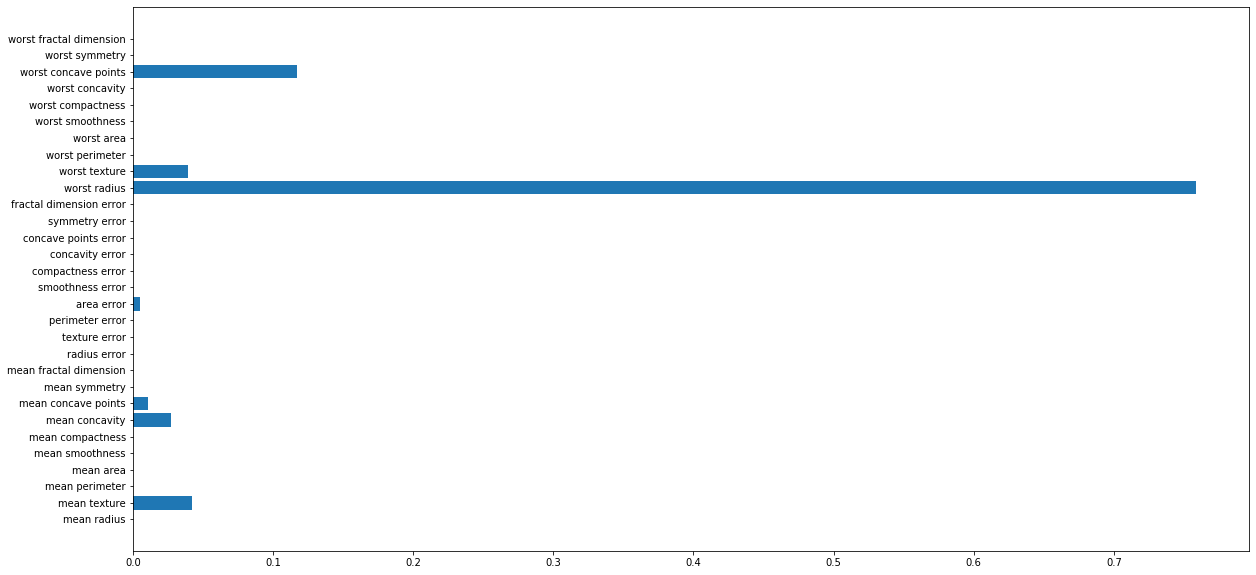

In [15]:
import matplotlib.pyplot as plt

def feature_importance(node, importance_list, criterion):
    if type(node) == dict:
        col = node['column']
        y = node['y']
        size = len(y)
        if criterion == 'gini':
            importance_score = size * (gini(y) - node['score'])
            importance_list[col] = importance_list[col] + importance_score
            feature_importance(node['left'], importance_list, 'gini')
            feature_importance(node['right'], importance_list, 'gini')
        else:
            importance_score = size * node['score']
            importance_list[col] = importance_list[col] + importance_score
            feature_importance(node['left'], importance_list, 'entropy')
            feature_importance(node['right'], importance_list, 'entropy')

        return None
    else: 
        return None
    
importance_list = [0] * np.shape(x_train)[1]
feature_importance(tree_gini, importance_list, 'gini')
importance_list = importance_list/sum(importance_list)

col_name = list(x_train.columns)
index = np.arange(len(col_name))
fig, ax = plt.subplots(figsize = (20,10))
ax.barh(index, importance_list)
ax.set_yticks(index)
ax.set_yticklabels(col_name)
plt.show()


Random Forest implementation by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

arguments:
1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [16]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        return None

    def build_forest(self, x_train, y_train):
        forest = []
        for i in range(self.n_estimators):
            #print(i,'th tree')
            row_list = range(np.shape(x_train)[0])
            row_index = random.choices(row_list, k=np.shape(x_train)[0])
            boostrap_x = x_train.iloc[row_index, :].reset_index(drop=True)
            boostrap_y = y_train.iloc[row_index].reset_index(drop=True)
            decisiontree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            tree = decisiontree.build_tree(boostrap_x, boostrap_y)
            forest.append(tree)
        return forest
    
    def build_forest_randboost(self, x_train, y_train):
        forest = []
        for i in range(self.n_estimators):
            #print(i,'th tree')
            row_list = range(np.shape(x_train)[0])
            row_index = random.choices(row_list, k=random.randint(1,np.shape(x_train)[0]))
            boostrap_x = x_train.iloc[row_index, :].reset_index(drop=True)
            boostrap_y = y_train.iloc[row_index].reset_index(drop=True)
            decisiontree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            tree = decisiontree.build_tree(boostrap_x, boostrap_y)
            forest.append(tree)
        return forest

            

#### Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.



In [17]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10forest = clf_10tree.build_forest(x_train, y_train)
clf_10forest_prediction = []
for tree in clf_10forest:
    clf_10forest_prediction.append(pred(tree, x_test))
clf_10forest_prediction = pd.DataFrame(clf_10forest_prediction)
clf_10tree_prediction = []
for cols in range(np.shape(clf_10forest_prediction)[1]):
    col = clf_10forest_prediction.iloc[:,cols]
    unique, counts = np.unique(col, return_counts=True)
    unique=list(unique)
    counts=list(counts)
    clf_10tree_prediction.append(unique[counts.index(max(counts))])
acc_clf_10forest = accuracy_score(y_test, clf_10tree_prediction) 

print('10_forest acc: ',acc_clf_10forest)

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100forest = clf_100tree.build_forest(x_train, y_train)
clf_100forest_prediction = []
for tree in clf_100forest:
    clf_100forest_prediction.append(pred(tree, x_test))
clf_100forest_prediction = pd.DataFrame(clf_100forest_prediction)
clf_100tree_prediction = []
for cols in range(np.shape(clf_100forest_prediction)[1]):
    col = clf_100forest_prediction.iloc[:,cols]
    unique, counts = np.unique(col, return_counts=True)
    unique=list(unique)
    counts=list(counts)
    clf_100tree_prediction.append(unique[counts.index(max(counts))])
acc_clf_100forest = accuracy_score(y_test, clf_100tree_prediction) 

print('100_forest acc: ',acc_clf_100forest)

10_forest acc:  0.9440559440559441
100_forest acc:  0.9230769230769231


#### Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [18]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features_forest = clf_random_features.build_forest(x_train, y_train)
clf_random_features_forest_prediction = []
for tree in clf_random_features_forest:
    clf_random_features_forest_prediction.append(pred(tree, x_test))
clf_random_features_forest_prediction = pd.DataFrame(clf_random_features_forest_prediction)
clf_random_features_prediction = []
for cols in range(np.shape(clf_random_features_forest_prediction)[1]):
    col = clf_random_features_forest_prediction.iloc[:,cols]
    unique, counts = np.unique(col, return_counts=True)
    unique=list(unique)
    counts=list(counts)
    clf_random_features_prediction.append(unique[counts.index(max(counts))])
acc_clf_random_features = accuracy_score(y_test, clf_random_features_prediction) 

print('random_features acc: ', acc_clf_random_features)


clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features_forest = clf_all_features.build_forest(x_train, y_train)
clf_all_features_forest_prediction = []
for tree in clf_all_features_forest:
    clf_all_features_forest_prediction.append(pred(tree, x_test))
clf_all_features_forest_prediction = pd.DataFrame(clf_all_features_forest_prediction)
clf_all_features_prediction = []
for cols in range(np.shape(clf_all_features_forest_prediction)[1]):
    col = clf_all_features_forest_prediction.iloc[:,cols]
    unique, counts = np.unique(col, return_counts=True)
    unique=list(unique)
    counts=list(counts)
    clf_all_features_prediction.append(unique[counts.index(max(counts))])
acc_clf_all_features = accuracy_score(y_test, clf_all_features_prediction) 

print('all_features acc: ', acc_clf_all_features)

random_features acc:  0.958041958041958
all_features acc:  0.9440559440559441
